### _Activity feature extractor: Network structures_
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Trying different network structures for extracting action features from a video

In [1]:
## Imports
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, Input, Concatenate,MaxPooling3D, Reshape
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import numpy as np
import pylab as plt
import keras
import keras.backend as K

## Custom scripts
import lscript as lsp
import dataset as dset

Using TensorFlow backend.


In [16]:
## Defining variables
time_step=50 # Number of frames to be skipped
imagefolderpath= ('/nobackup/leopauly/KTH_new/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath)) # Checking if directory of video dataset exists
LOG_DIR='./logdir'
custom_global_step=0
hidden_num = 24 # Number of neurons in hidden layer of LSTM
nb_classes=3
lr_rate=.0005
batch_size = 5
nb_seq_train=360
no_of_batches = int(nb_seq_train / batch_size)
epoch = 10
height=150
width=300
channel=1
lstm_h_units=10
cluster_length=5

True


#### Loading and displaying data

label:2.0
Video_seq shape: (32, 50, 150, 300) Label shape (32,)


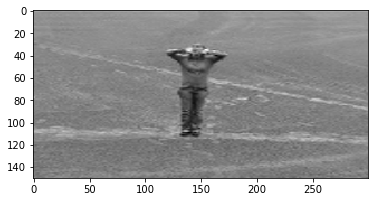

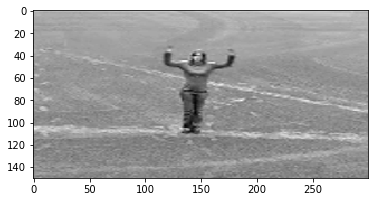

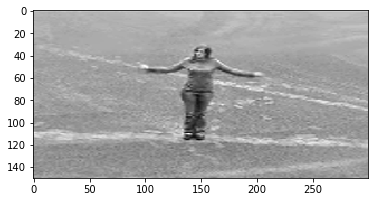

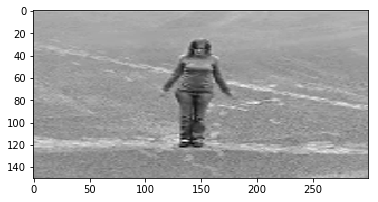

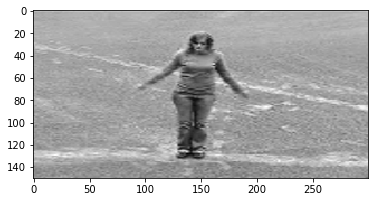

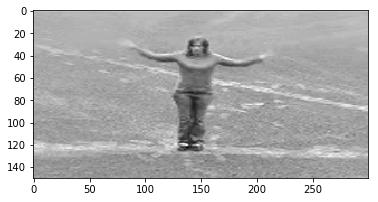

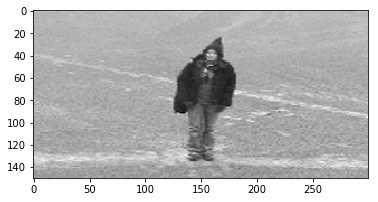

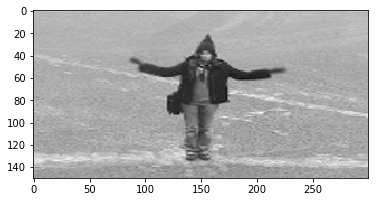

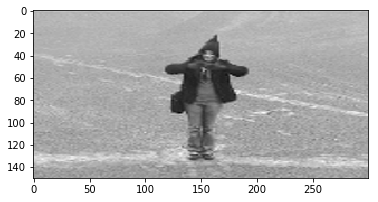

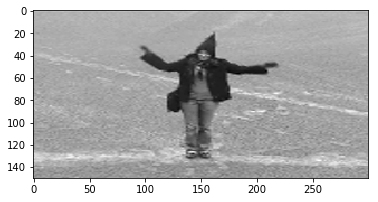

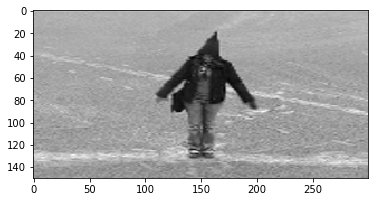

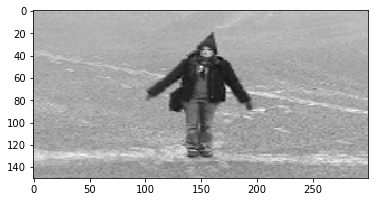

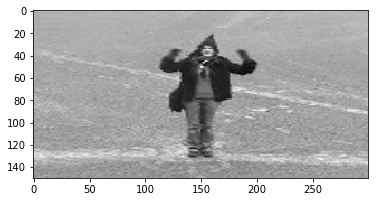

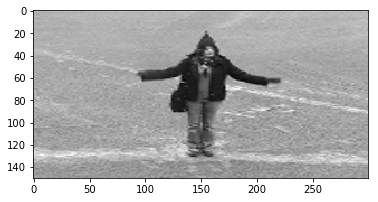

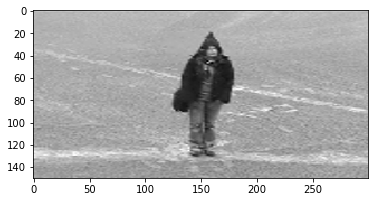

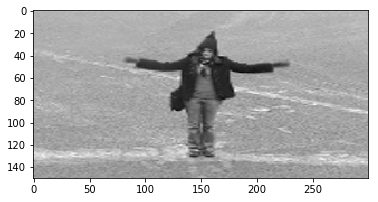

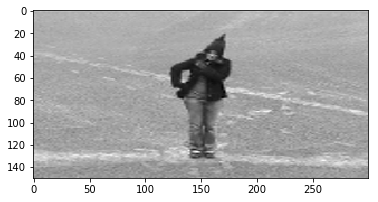

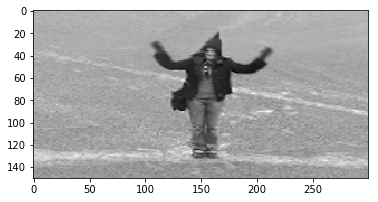

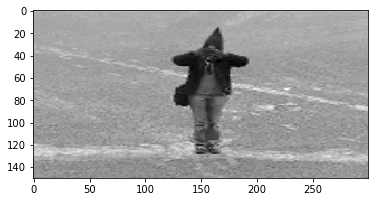

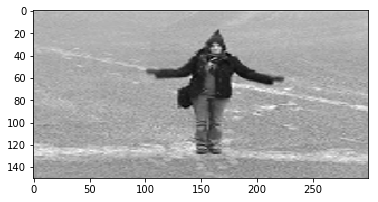

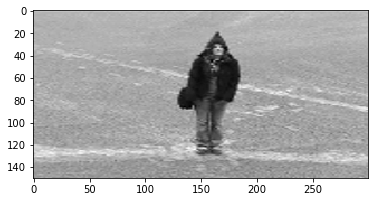

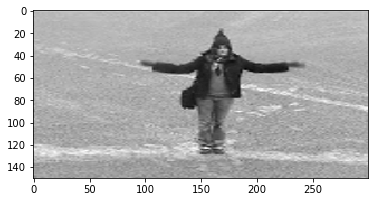

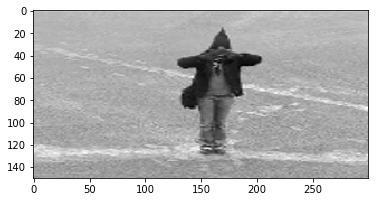

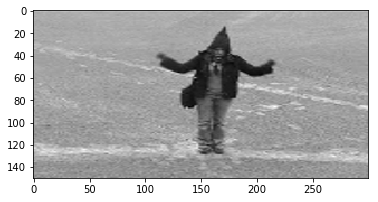

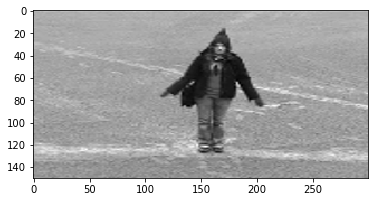

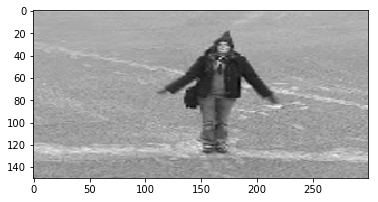

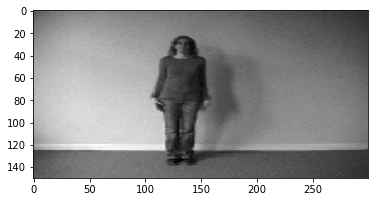

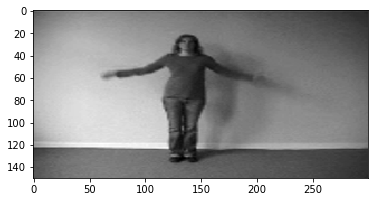

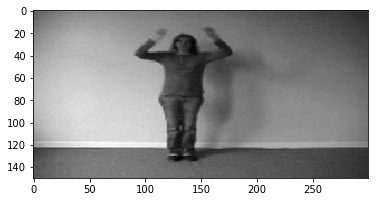

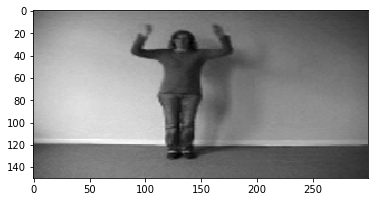

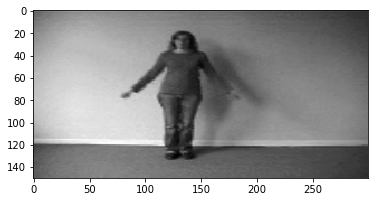

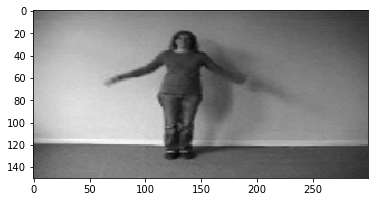

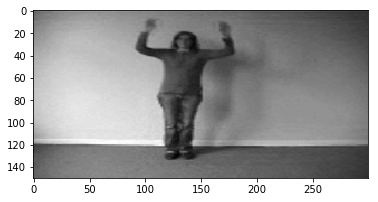

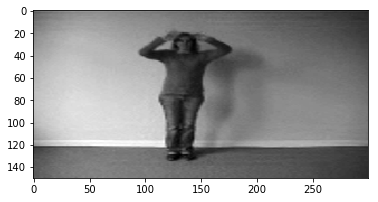

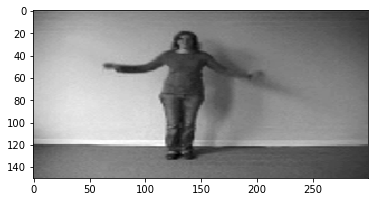

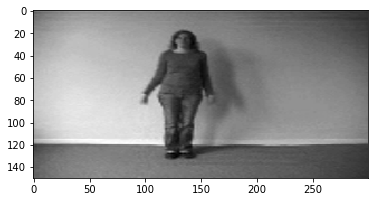

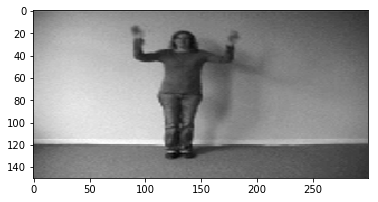

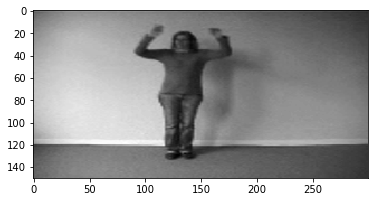

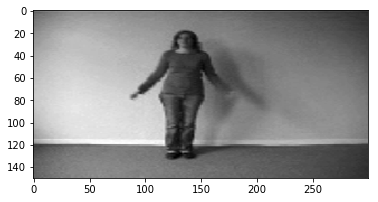

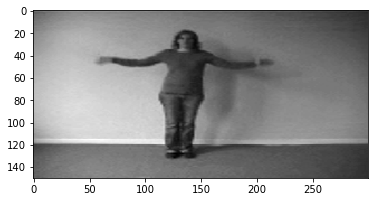

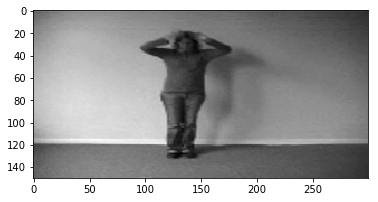

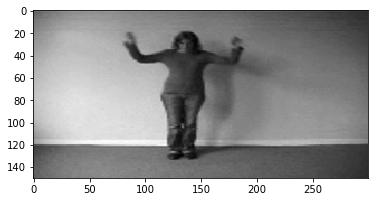

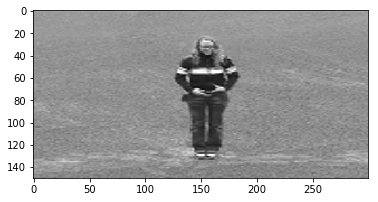

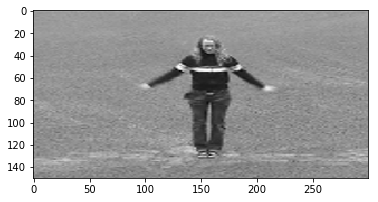

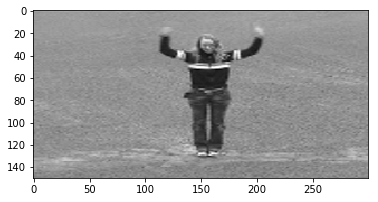

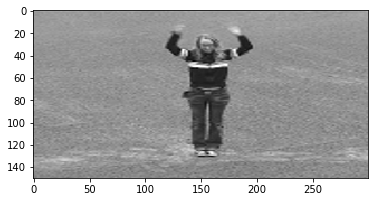

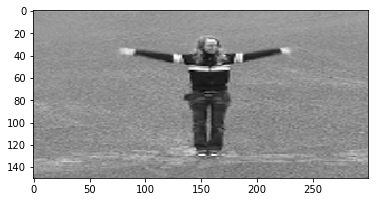

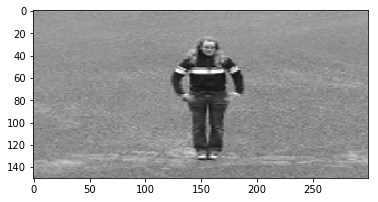

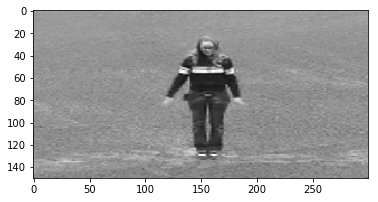

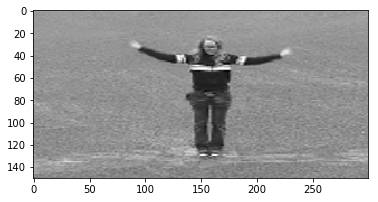

In [3]:
# TODO: Make display like an animation
x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
item_num=1
lsp.view_video_seq(x,y,time_step,item_num)

#### Defining model

In [17]:
## Defining placeholders in tf
data_1 = tf.placeholder(tf.float32, [None, cluster_length, height, width, channel]) #step_size=No: of frames in video sequence
data_2 = tf.placeholder(tf.float32, [None, cluster_length, height, width, channel])
data_3 = tf.placeholder(tf.float32, [None, cluster_length, height, width, channel])
target = tf.placeholder(tf.float32, [None, nb_classes])

In [19]:
## Suggested Network structure 2a: Conv3D followed by LSTM

def cnn_modeling():
    input_cnn = Input(shape=(cluster_lengh, height, width, channel))
    
    cnn_1=Conv3D(filters=64, kernel_size=(3,3,3),padding='same',activation='relu')(input_cnn)
    pool_1=MaxPooling3D(pool_size=(1, 2, 2),strides=(1, 2, 2),padding='valid')(cnn_1)
    
    cnn_2=Conv3D(filters=128, kernel_size=(3,3,3),padding='same',activation='relu')(pool_1)
    pool_2=MaxPooling3D(pool_size=(2, 2, 2),strides=(2, 2, 2),padding='valid')(cnn_2)
    
    cnn_3a=Conv3D(filters=256, kernel_size=(3,3,3),padding='same',activation='relu')(pool_2)
    cnn_3b=Conv3D(filters=256, kernel_size=(3,3,3),padding='same',activation='relu')(cnn_3a)
    pool_3=MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2),padding='valid')(cnn_3b)
    
    #cnn_4a=Conv3D(filters=512, kernel_size=(3,3,3),padding='same',activation='relu')(pool_3)
    #cnn_4b=Conv3D(filters=512, kernel_size=(3,3,3),padding='same',activation='relu')(cnn_4a)
    #pool_4=MaxPooling3D(pool_size=(2, 2, 2),strides=(2, 2, 2),padding='valid')(cnn_4b)
    
    #cnn_5a=Conv3D(filters=64, kernel_size=(3,3,0),padding='same',activation='relu')(pool_4)
    #cnn_5b=Conv3D(filters=64, kernel_size=(3,3,0),padding='same',activation='relu')(cnn_5a)
    #ßpool_5=MaxPooling3D(pool_size=(time_step, 8, 8),strides=(2, 4, 4),padding='valid')(cnn_5b)
    
    #flat= Flatten()(pool_3)
    flat=Reshape([1,-1])(pool_3)
    
    # FC layers group
    fc_1=Dense(4096, activation='relu')(flat)
    drop_1=Dropout(.5, name='do1')(fc_1)
    fc_2=Dense(4096, activation='relu')(drop_1)
    drop_2=Dropout(.5, name='do2')(fc_2)
    fc_2=Dense(487, name='fc8')(drop_2)
    
    model_cnn=Model(input_cnn,fc_2)
    print(model_cnn.summary())
    return model_cnn

input_1 = Input(shape=(cluster_length, height, width, channel))
input_2 = Input(shape=(cluster_length, height, width, channel))
input_3 = Input(shape=(cluster_length, height, width, channel))

model_cnn=cnn_modeling()
layer1_1=model_cnn(inputs=input_1)
layer1_2=model_cnn(inputs=input_2)
layer1_3=model_cnn(inputs=input_3)

concat= keras.layers.concatenate([layer1_1, layer1_2,layer1_3],1)
layer2=keras.layers.LSTM(lstm_h_units,return_sequences=True)(concat)
layer3= Reshape([3*lstm_h_units])(layer2)
model=Model([input_1,input_2,input_3],layer2)
logit_out=model([data_1,data_2,data_3])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 5, 150, 300, 1)    0         
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 5, 150, 300, 64)   1792      
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 5, 75, 150, 64)    0         
_________________________________________________________________
conv3d_36 (Conv3D)           (None, 5, 75, 150, 128)   221312    
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 2, 37, 75, 128)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 2, 37, 75, 256)    884992    
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 2, 37, 75, 256)    1769728   
__________

In [9]:
## Suggested Network structure 2b: Conv3D followed by LSTM
input_1 = Input(shape=(time_step, height, width, channel))
input_2 = Input(shape=(time_step, height, width, channel))
input_3 = Input(shape=(time_step, height, width, channel))

conv3D=Conv3D(filters=1, kernel_size=(3,3,3),padding='same')
layer1_1=conv3D(inputs=input_1)
layer1_2=conv3D(inputs=input_2)
layer1_3=conv3D(inputs=input_3)

max_pool=MaxPooling3D(pool_size=(time_step, 8, 8),strides=(2, 4, 4),padding='valid')
layer_2a = max_pool(layer1_1)
layer_2b = max_pool(layer1_2)
layer_2c = max_pool(layer1_3)

layer_3a = Reshape([1,-1])(layer_2a)
layer_3b = Reshape([1,-1])(layer_2b)
layer_3c = Reshape([1,-1])(layer_2c)

#layer_3a = Flatten()(layer_2a)
#layer_3b = Flatten()(layer_2b)
#layer_3c = Flatten()(layer_2c)

concat= keras.layers.concatenate([layer_3a, layer_3b,layer_3c],1)
layer4=keras.layers.LSTM(lstm_h_units,return_sequences=True)(concat)
layer5= Reshape([lstm_h_units*3])(layer4)
out = Dense(nb_classes)(layer5)

model=Model([input_1,input_2,input_3],out)
logit_out=model([data_1,data_2,data_3])
shape=tf.shape(logit_out)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (None, 50, 150, 300,  0                                            
____________________________________________________________________________________________________
input_22 (InputLayer)            (None, 50, 150, 300,  0                                            
____________________________________________________________________________________________________
input_23 (InputLayer)            (None, 50, 150, 300,  0                                            
____________________________________________________________________________________________________
conv3d_33 (Conv3D)               (None, 50, 150, 300,  28          input_21[0][0]                   
                                                                   input_22[0][0]          

In [4]:
## Suggested Network structure 1: Conv3D followed by ConvLSTM
input_1 = Input(shape=(3, height, width, channel))
input_2 = Input(shape=(3, height, width, channel))
input_3 = Input(shape=(3, height, width, channel))

conv3D=Conv3D(filters=1, kernel_size=(3,3,0),padding='same')
layer1_1=conv3D(inputs=input_1)
layer1_2=conv3D(inputs=input_2)
layer1_3=conv3D(inputs=input_3)

concatenated = keras.layers.concatenate([layer1_1, layer1_2,layer1_3],1)
model_out=ConvLSTM2D(filters=1, kernel_size=(5, 5),padding='SAME', return_sequences=True)(concatenated)

model=Model([input_1,input_2,input_3],model_out)
inter_out=model([data_1,data_2,data_3])
print(model.summary())

layer2=tf.nn.max_pool3d(inter_out,ksize=(1,1,4,4,1),strides=(1,1,4,4,1),padding='VALID')
size1=tf.shape(layer2)
shape1=tf.shape(layer2)
fc = tf.reshape(layer2,[batch_size, 133200]) #shape1[1]*shape1[2]*shape1[3]*shape1[4]])  #138750
#shape2=tf.shape(fc)
out=tf.layers.dense(fc,nb_classes)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 150, 300, 1 0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 3, 150, 300, 1 0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 3, 150, 300, 1 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 3, 150, 300, 1 1           input_1[0][0]                    
                                                                   input_2[0][0]           

In [5]:
predictions= tf.nn.softmax(logit_out)
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=target,logits=logit_out))
optimizer = tf.train.AdamOptimizer(lr_rate)
minimize = optimizer.minimize(cross_entropy)
mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(predictions, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

## Defining variables for writing summary
#tf.summary.histogram("predictions",predictions )
tf.summary.scalar("cross_entropy",cross_entropy )
tf.summary.scalar("test_error",error )
summary_op = tf.summary.merge_all()

#### Training model

In [6]:
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

saver = tf.train.Saver()
train_writer = tf.summary.FileWriter('./logdir', sess.graph)

for i in range(epoch):
    ptr = 0
    for iteration in range(no_of_batches):
        #x=dset.batch_gen(0+(batch_size*iteration),batch_size+(batch_size*iteration),batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
        x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
        x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
        y_onehot = lsp.one_hot(y,nb_classes)
        #print(x.shape,y.shape)
        
        summ_string,_=sess.run([summary_op,minimize],{data_1: x,data_2:x,data_3:x, target: y_onehot})
        train_writer.add_summary(summ_string,custom_global_step+1) # Writing summary to disc
        custom_global_step+=1
        
        print('Iteration {}'.format(iteration))
    print ('Epoch {}'.format(str(i)))

saver.save(sess, os.path.join(LOG_DIR, "activity_model.ckpt"))

ResourceExhaustedError: OOM when allocating tensor with shape[5,1,50,150,300]
	 [[Node: model_1/conv3d_1/convolution = Conv3D[T=DT_FLOAT, padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_2_0/_9, conv3d_1/kernel/read)]]
	 [[Node: Mean/_27 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_897_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'model_1/conv3d_1/convolution', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-ed2412b9b3c2>", line 30, in <module>
    logit_out=model([data_1,data_2,data_3])
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 2061, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 2212, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/convolutional.py", line 172, in call
    dilation_rate=self.dilation_rate)
  File "/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3252, in conv3d
    data_format='NDHWC')
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 661, in convolution
    op=op)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 331, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 653, in op
    name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 140, in _non_atrous_convolution
    name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 529, in conv3d
    strides=strides, padding=padding, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[5,1,50,150,300]
	 [[Node: model_1/conv3d_1/convolution = Conv3D[T=DT_FLOAT, padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_2_0/_9, conv3d_1/kernel/read)]]
	 [[Node: Mean/_27 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_897_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


#### Evaluating performance

In [ ]:
test_batch_size=10
x,y=dset.batch_gen_train(nb_classes,test_batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
y_onehot = lsp.one_hot(y,nb_classes)

error_rate= sess.run(error,feed_dict={data_1: x,data_2:x,data_3:x, target: y_onehot})
print('error {} %'.format(error_rate*100))

#### Visualising layers

In [ ]:
x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
y_onehot = lsp.one_hot(y,nb_classes)

img=x[12]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result6.png')
plt.show()

#### Restoring a model and then visualising layers

In [ ]:
sess=tf.InteractiveSession() 
saved_model = tf.train.import_meta_graph('./logdir/activity_model.ckpt.meta')
saved_model.restore(sess, tf.train.latest_checkpoint('./logdir'))

In [ ]:
img=x[1]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result3.png')
plt.show()

#### Tensorboard

In [ ]:
# Checking the items in the log directory
!tensorboard --inspect --logdir='./logdir/'

# Running tensorflow
print('If on windows system go to: http://localhost:6006')
!tensorboard --logdir='./logdir/'

In [ ]:
sess.close()